## **Step 2: Import All the Required Libraries**

In [1]:
import os
import torch
from datasets import load_dataset
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import torch

2025-03-22 14:30:37.059561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 14:30:37.059689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 14:30:37.208192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Tuning Example Format :**

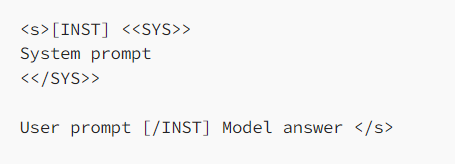

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

In [2]:
# Load dataset (you can process it here)
dataset = load_dataset("ccdv/pubmed-summarization")

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 119924
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6658
    })
})

In [4]:
# 2. Load Pegasus tokenizer and model
model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [5]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
model = model.cuda()

# 4. Preprocessing function
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = tokenizer(examples["article"], max_length=max_input_length, truncation=True, padding="max_length")
    targets = tokenizer(examples["abstract"], max_length=max_target_length, truncation=True, padding="max_length")

    inputs["labels"] = targets["input_ids"]
    return inputs

Using 2 GPUs


In [6]:
dataset['train']['abstract'][2]

'tardive dystonia ( td ) is a serious side effect of antipsychotic medications , more with typical antipsychotics , that is potentially irreversible in affected patients . \n studies show that newer atypical antipsychotics have a lower risk of td . as a result , many clinicians may have developed a false sense of security when prescribing these medications . \n we report a case of 20-year - old male with hyperthymic temperament and borderline intellectual functioning , who developed severe td after low dose short duration exposure to atypical antipsychotic risperidone and then olanzapine . \n the goal of this paper is to alert the reader to be judicious and cautious before using casual low dose second generation antipsychotics in patient with no core psychotic features , hyperthymic temperament , or borderline intellectual functioning suggestive of organic brain damage , who are more prone to develop adverse effects such as td and monitor the onset of td in patients taking atypical ant

In [7]:
# Take first 1000 samples for training and 100 for testing
small_train_dataset = dataset["train"].select(range(10))
small_test_dataset = dataset["test"].select(range(2))

# Now map only on these smaller datasets
tokenized_train = small_train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=16,
    remove_columns=small_train_dataset.column_names,
    num_proc=4
)

tokenized_test = small_test_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=16,
    remove_columns=small_test_dataset.column_names,
    num_proc=4
)


Map (num_proc=4):   0%|          | 0/10 [00:00<?, ? examples/s]

num_proc must be <= 2. Reducing num_proc to 2 for dataset of size 2.


Map (num_proc=2):   0%|          | 0/2 [00:00<?, ? examples/s]

In [8]:
# Assuming `model` and `tokenizer` have already been loaded (e.g., Pegasus) and your preprocess_function is defined

# Create data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./pegasus-finetuned-mvp",
    evaluation_strategy="steps",
    save_steps=100,                 # Save checkpoint every 100 steps
    logging_steps=10,               # Log every 10 steps
    learning_rate=3e-5,
    per_device_train_batch_size=2,  # Adjust as needed based on your GPU
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    predict_with_generate=True,
    remove_unused_columns=False,
    fp16=True,                      # Use mixed precision if supported
    logging_dir="./logs",
    report_to="tensorboard"
)

# Initialize the trainer with the small tokenized datasets
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [9]:
# 9. Start training
trainer.train()

# 10. Save final model
trainer.save_model("./pegasus-finetuned-pubmed-mvp")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
